# Bi-Objective optimization via $\epsilon$-constraint method

In [24]:
using CSV, DataFrames
import PythonPlot as plt
using Revise, MGBO

In [25]:
const DATA_DIR = "../data/"
const IMG_DIR = "../img/"

"../img/"

## Read input data

In [26]:
input_df = CSV.read(joinpath(DATA_DIR, "input/nominal_scenario.csv"), DataFrame)
T = nrow(input_df)
first(input_df, 3)

3×5 DataFrame
 Row │ t      P_PV     P_WT     P_Load   Price   
     │ Int64  Float64  Float64  Float64  Float64 
─────┼───────────────────────────────────────────
   1 │     1      0.0    30.09    37.76    0.324
   2 │     2      0.0    27.06    44.54    0.36
   3 │     3      0.0    26.91    48.9     0.288

In [27]:
input_data = ScenarioData(;
    P_PV = input_df.P_PV,
    P_WT = input_df.P_WT,
    P_L = input_df.P_Load,
    P_CL = input_df.P_Load .* MGBO.P_CL_ratio,
    ρ_UG_b = input_df.Price,
    ρ_UG_s = input_df.Price .* MGBO.β_UG
)
;

## Build payoff table 

In [28]:
payoff, model = MGBO.build_payoff_table(input_data; log_level=0)
payoff

2×2 Matrix{Float64}:
 297.732  823.0
 748.013  136.543

## Bi-objective optimization via augmented $\epsilon$-constraint method

In [29]:
# range of f2 
f2_max = payoff[1, 2]
f2_min = payoff[2, 2]
r =  f2_max - f2_min
# number ϵ grid points
G = 31
ϵ_grid = range(f2_min, f2_max; length=G)

136.5431864:22.881882537543746:822.9996625263124

In [47]:
#TODO: integrate this logic into bi_objective_minimize directly

pareto_front = zeros(2, G)  # each col is (f1, f2) point
models = Array{Any}(undef, G)
for (i, ϵ) in enumerate(ϵ_grid)
    model = bi_objective_minimize(input_data, ϵ, r)
    pareto_front[:, i] .= get_value.((model[:f1], model[:f2]))
    models[i] = model
end

In [48]:
pareto_front

2×31 Matrix{Float64}:
 748.013  693.499  670.383  649.892  …  309.968  303.099  299.323  297.732
 136.543  159.425  182.307  205.189     754.354  777.236  800.118  823.0

### visualize the Pareto front

In [49]:
plt.rc("font", size=13)
plt.rc("legend", fontsize=11)

Python: None

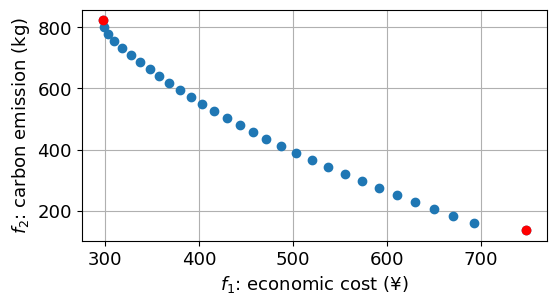

In [50]:
fig = plt.figure(figsize=(6,  3))  # inch
plt.plot(pareto_front[1, :], pareto_front[2, :], "o")
plt.plot(pareto_front[1, 1], pareto_front[2, 1], "or")
plt.plot(pareto_front[1, end], pareto_front[2, end], "or")
plt.xlabel(raw"$f_1$: " * "economic cost (¥)")
plt.ylabel(raw"$f_2$: " * "carbon emission (kg)")
plt.grid(true)
# plt.legend()
fig  # show the plot

In [51]:
fig.savefig(joinpath(IMG_DIR, "bi.pdf"), bbox_inches="tight")

Python: None

## TOPSIS
Note that in the above figure, the order of points in `pareto_front` is from right to left.

In [52]:
E = pareto_front'
w = [0.7, 0.3]
topsis = run_TOPSIS(E, w);

In [53]:
@show topsis[:Aw] topsis[:Ab];

topsis[:Aw] = [1.5008191761832306, 0.4949340131970674]
topsis[:Ab] = [-0.8916473593044586, -0.49493401319706715]


In [54]:
topsis[:sb]

31-element Vector{Float64}:
 0.2926582241596478
 0.3222061316093845
 0.33805996388914594
 0.35520646250181687
 0.3754073076752724
 0.3975946945398091
 0.42156222627404993
 0.4469912256037313
 0.47418660327752193
 0.5019904938589312
 ⋮
 0.7252066575319303
 0.7270634849244002
 0.727760812961986
 0.7271575798024991
 0.7254356693106618
 0.7228345028334994
 0.7189830572200633
 0.7135987355374946
 0.7073417758403523

In [55]:
@show topsis[:Aw] topsis[:Ab];

topsis[:Aw] = [1.5008191761832306, 0.4949340131970674]
topsis[:Ab] = [-0.8916473593044586, -0.49493401319706715]


Note that in the above figure, the order of points in `pareto_front` is from right to left.

In [56]:
sb_max, idx = findmax(topsis[:sb])
idx_fig = size(pareto_front, 2) + 1 - idx
@show sb_max idx idx_fig

sb_max = 0.727760812961986
idx = 25
idx_fig = 7


7

In [57]:
# best compromise
pareto_front[:, idx]

2-element Vector{Float64}:
 337.4044262822749
 685.7083673010497

### Visualize the similarity together with the Pareto front

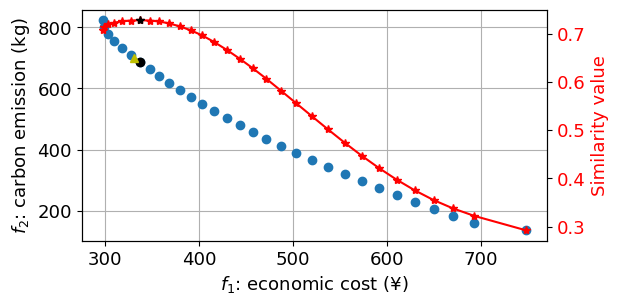

In [70]:
fig = plt.figure(figsize=(6,  3))  # inch
plt.plot(pareto_front[1, :], pareto_front[2, :], "o")
plt.plot(pareto_front[1, idx], pareto_front[2, idx], "ok")
plt.plot(331.31, 699.66, "^y")
plt.xlabel(raw"$f_1$: " * "economic cost (¥)")
plt.ylabel(raw"$f_2$: " * "carbon emission (kg)")
plt.grid(true)

plt.twinx()
plt.plot(pareto_front[1, :], topsis[:sb], "*-r")
plt.plot(pareto_front[1, idx], topsis[:sb][idx], "*k")
plt.ylabel("Similarity value", color="r")
plt.yticks(color="r")
# plt.grid(true)
fig

In [59]:
fig.savefig(joinpath(IMG_DIR, "similarity.pdf"), bbox_inches="tight")

Python: None

### Visualize scheduling using the best compromise solution

In [60]:
function plot_stacked_bar(res::Dict, ax)
    P_MT = res[:P_MT]
    P_BS = res[:P_BS]
    P_BS_pos = replace(x -> max(x, 0.0), P_BS)
    P_BS_neg = replace(x -> min(x, 0.0), P_BS)
    P_UG = res[:P_UG]
    P_UG_pos = replace(x -> max(x, 0.0), P_UG)
    P_UG_neg = replace(x -> min(x, 0.0), P_UG)
    P_shed = res[:P_shed]
    T = length(P_MT)
    # fig = plt.figure(figsize=(6, 3))
    # first plot positive values
    plt.sca(ax)
    plt.bar(1:T, P_MT, label=raw"$P_{\text{MT}}$", color="C0") # https://stackoverflow.com/a/47773515/14020277
    plt.bar(1:T, P_BS_pos, bottom=P_MT, label=raw"$P_{\text{BS}}$", color="C1")
    plt.bar(1:T, P_UG_pos, bottom=P_MT .+ P_BS_pos, label=raw"$P_{\text{UG}}$", color="C2")
    plt.bar(1:T, P_shed, bottom=P_MT .+ P_BS_pos .+ P_UG_pos, label=raw"$P_{\text{shed}}$", color="C3")
    # now plot negative values
    plt.bar(1:T, P_BS_neg, color="C1")
    plt.bar(1:T, P_UG_neg, bottom=P_BS_neg, color="C2")
    plt.legend()
    # plt.xlabel("Time (h)")
    plt.ylabel("Power (kW)")
    plt.gca().set_axisbelow(true) # https://stackoverflow.com/a/68344604/14020277
    plt.grid(true)
end

plot_stacked_bar (generic function with 1 method)

In [61]:
# best model
best_model = models[idx];
res = Dict(
    :P_MT => get_value.(best_model[:P_MT]),
    :P_BS => get_value.(best_model[:P_BS]),
    :P_UG => get_value.(best_model[:P_UG]),
    :P_shed => get_value.(best_model[:P_shed]),
)
;

Dict{Symbol, Vector{Float64}} with 4 entries:
  :P_UG   => [0.0, 7.48, 36.99, 20.9353, 3.37, 0.0, 42.215, 0.0, 0.0, 0.0  …  0…
  :P_BS   => [-2.33, 0.0, -20.0, -19.7753, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0…
  :P_shed => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9775, 26.56  …  10.3275…
  :P_MT   => [10.0, 10.0, 5.0, 10.0, 15.0, 18.46, 20.0, 23.5925, 25.0, 25.0  … …

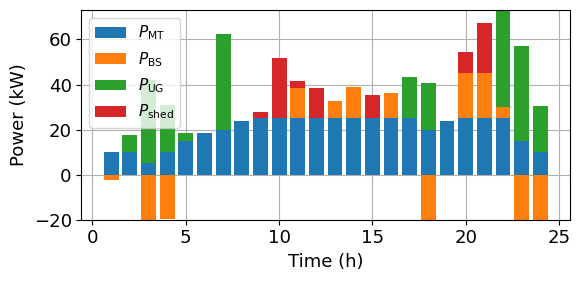

In [64]:

fig = plt.figure(figsize=(6, 3), layout="tight")
plot_stacked_bar(res, plt.gca())
plt.xlabel("Time (h)")
fig

In [65]:
fig.savefig(joinpath(IMG_DIR, "compromise.pdf"), bbox_inches="tight")

Python: None

## Weighted single-objective optimization

In [114]:
weights = [0.7, 0.3]
model = weighted_single_objective_minimize(input_data, weights, log_level=0)
;

In [115]:
@show model[:result][:f1] model[:result][:f2];

(model[:result])[:f1] = 748.0126057599999
(model[:result])[:f2] = 136.5431864


In [116]:
model2 = bi_objective_minimize(input_data, model[:result][:f2], r)
get_value.((model2[:f1], model2[:f2]))

(748.0126057599999, 136.5431864)